# Import

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime, timedelta, date
from sklearn import preprocessing

import plotly.graph_objects as go

# pandas max row 
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

# Data Load

- 시간 전처리: index화 + datatime 변형
- 시간 보정 작업: index 기준 나머지 
- 소수점 변환: 용해 온도, 교반속도 소수점 변환

In [2]:
df = pd.read_csv('경진대회용 용해탱크 데이터셋.csv', encoding='cp949')

# 시간 정보 각 index별 6초 단위 값 삽입
def num_change(x):
    remainder = divmod(x, 10)[1]
    change_second = remainder * 6
    
    if len(str(change_second)) == 1:
        value = '0' + str(change_second)
    else: 
        value = str(change_second)
    
    return value
df['NUM'] = df['NUM'].agg(lambda x: num_change(x))

df_cp = df.copy()
df_cp['STD_DT'] = df_cp['STD_DT'] + ':' + df_cp['NUM']

# 시간 정보 : object => datatime으로 변형 / index화
df_cp['STD_DT'] = df_cp['STD_DT'].apply(lambda x : pd.to_datetime(str(x), format='%Y-%m-%d %H:%M:%S'))

# Data Preprocessing

In [3]:
df_cp = df_cp.set_index(['STD_DT'])

## 소수점 변환: 용해 온도(MELT_TEMP), 교반속도(MOTORSPEED)
def change_value(x):
    operation_value = str(x)             # str 형식으로 변환
    length_value = len(operation_value)  # 길이 확인

    if length_value == 1:
        value = '0.' + operation_value
    elif length_value == 2:
        value = operation_value[0] + '.' + operation_value[1]
    else: 
        int_cnt = length_value - 1
        value = operation_value[:int_cnt] + '.' + operation_value[int_cnt]
        

    change_value = float(value)
    return change_value

df_cp['MELT_TEMP'] = df_cp['MELT_TEMP'].agg(lambda x: change_value(x))
df_cp['MOTORSPEED'] = df_cp['MOTORSPEED'].agg(lambda x: change_value(x))

del df_cp['NUM']

df_cp.head(20)

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
STD_DT,,,,,
2020-03-04 00:00:00,48.9,11.6,631,3.19,OK
2020-03-04 00:00:06,43.3,7.8,609,3.19,OK
2020-03-04 00:00:12,46.4,15.4,608,3.19,OK
2020-03-04 00:00:18,37.9,21.2,606,3.19,OK
2020-03-04 00:00:24,79.8,173.6,604,3.21,OK
2020-03-04 00:00:30,74.3,172.2,603,3.21,OK
2020-03-04 00:00:36,39.0,21.2,602,3.19,OK
2020-03-04 00:00:42,49.3,15.2,600,3.19,OK
2020-03-04 00:00:48,42.7,0.0,599,3.19,OK


# EDA

#### [1] 불량과 정상 사이의 분포도 확인 
- Motospped(교반속도), MELT_TEMP(융해온도)가 높을 때의 경우 불량이 없음 => 이들에 대한 상관관계가 존재할까 확인

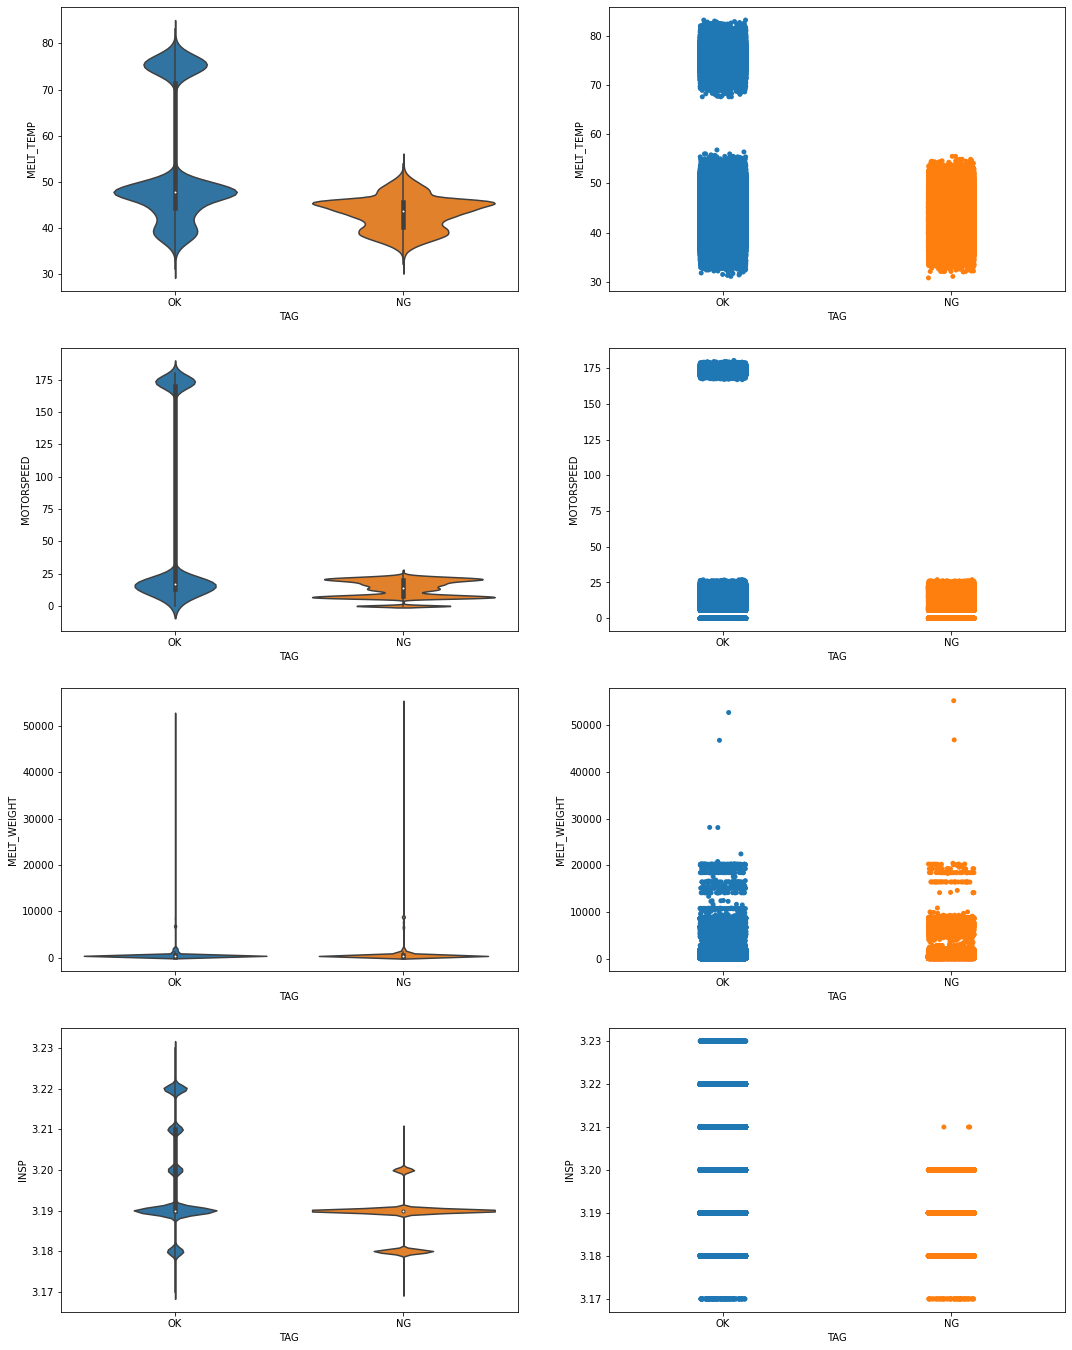

In [4]:
fig, ax = plt.subplots(4, 2, figsize = (18,24))
sns.violinplot(x='TAG', y='MELT_TEMP', data = df_cp, ax = ax[0,0])
sns.stripplot(x='TAG', y='MELT_TEMP', data = df_cp, ax = ax[0,1])

sns.violinplot(x='TAG', y='MOTORSPEED', data = df_cp, ax = ax[1,0])
sns.stripplot(x='TAG', y='MOTORSPEED', data = df_cp, ax = ax[1,1])

sns.violinplot(x='TAG', y='MELT_WEIGHT', data = df_cp, ax = ax[2,0])
sns.stripplot(x='TAG', y='MELT_WEIGHT', data = df_cp, ax = ax[2,1])

sns.violinplot(x='TAG', y='INSP', data = df_cp, ax = ax[3,0])
sns.stripplot(x='TAG', y='INSP', data = df_cp, ax = ax[3,1])
plt.show()

#### 상관관계 Plot
- 용해 온도와 교반 속도, 수분 함유량간의 양의 상관관계가 높음 
(수분 함유량의 경우 숫자로 되어있는 category)

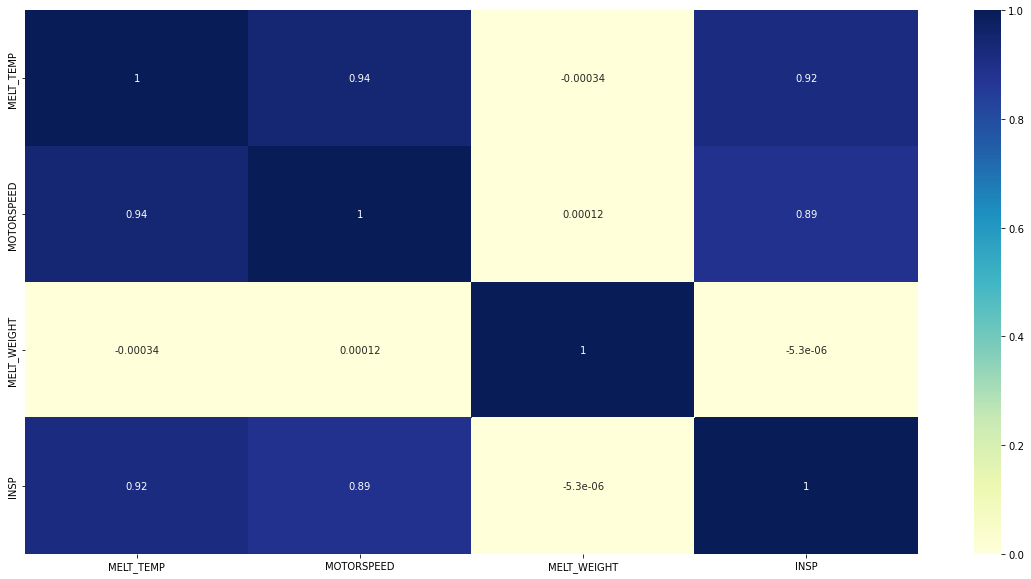

In [5]:
plt.figure(figsize=(20,10))
sns.heatmap(df_cp.iloc[:,:-1].corr(), annot=True, cmap="YlGnBu")
plt.show()

#### 불량이 발생한 시점 범위 확인 해보기 

- 참고사항: 하루에 발생하는 데이터 건수(14,400)

- 날짜별: 3월 17일 ~ 4월 14일 범위
- 시간별

In [13]:
not_ok = df_static[df_static['TAG'] == 1].reset_index()

# 날짜만 추출(어느날 분포)
not_ok['day'] = not_ok['STD_DT'].dt.date

In [19]:
df

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,00,489,116,631,3.19,OK
1,2020-03-04 0:00,06,433,78,609,3.19,OK
2,2020-03-04 0:00,12,464,154,608,3.19,OK
3,2020-03-04 0:00,18,379,212,606,3.19,OK
4,2020-03-04 0:00,24,798,1736,604,3.21,OK
...,...,...,...,...,...,...,...
835195,2020-04-30 23:59,30,755,1743,318,3.21,OK
835196,2020-04-30 23:59,36,385,206,317,3.19,OK
835197,2020-04-30 23:59,42,465,148,316,3.20,OK
835198,2020-04-30 23:59,48,467,0,314,3.19,OK


In [15]:
not_ok['day'].value_counts()

2020-03-29    11520
2020-03-27    11520
2020-03-28    11520
2020-03-30    11520
2020-03-26    11519
2020-03-31     7964
2020-03-25     7737
2020-03-23     6609
2020-03-21     6587
2020-03-24     6556
2020-03-22     6547
2020-04-04     6516
2020-03-20     6314
2020-04-03     6230
2020-04-01     6195
2020-04-05     6180
2020-04-02     6076
2020-04-12     4219
2020-04-11     4201
2020-04-06     3938
2020-03-19     3906
2020-04-10     3744
2020-04-13     3531
2020-04-07     3344
2020-04-09     3306
2020-04-08     3050
2020-03-18     2792
2020-03-17     2310
2020-04-14     1616
Name: day, dtype: int64

#### 불량 발생 전후의 변화량 확인

#### GLS 적용: 해당 부분 넘어가기

- 결과: 적용 실패(잔차 간의 행렬 구할 때 너무 값이 커져서 RAM이 터짐(이런)

In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence
from scipy.stats import t

In [10]:
df_static = df_cp.copy()
df_static['TAG'] = df_static['TAG'].agg(lambda x: 1 if x =='NG' else 0) 

feature_name = list(df_static.columns[:-1])
# 잔차 추가(augementation): 범주형 독립변수가 있으면 상수항은 포함시키지 않는다.
# value = sm.add_constant(value)

df_static = df_static.reset_index()

In [16]:
df_filered = df_static[df_static['STD_DT'].between('2020-03-16', '2020-03-18')]

In [17]:
# OLS 회귀 적용(이유: 시계열 가중치 얻기 위함)
model = sm.OLS.from_formula("TAG ~ 0 + " + "+".join(feature_name), data = df_filered).fit()

# 모델의 잔차 구함
ols_resid = model.resid

# 잔차 간의 시계열(일로 +1, -1)간의 회귀  
res_fit = sm.OLS(list(ols_resid[1:]), list(ols_resid[:-1])).fit()

# OLS 잔차 간의 상관계수의 계수(일관된 추정치 값)
rho = res_fit.params

print(res_fit.summary())

# 잔차 간의 상관계수 확인: 매우 높음
print("--------------------------------------------------------------")
print("잔차 간의 Corrleation(T 분포): " + str(res_fit.tvalues[0]))
print("잔차 간의 Corrleation(pvalue): " + str(res_fit.pvalues[0]))

from scipy.linalg import toeplitz #  퇴플리츠 행렬 modlue

# 시계열 길이 맞춘 퇴플리츠 행렬 생성 후 시걔열 간의 잔차 간의 상관정도를 행렬 만듦
order = toeplitz(np.arange(len(ols_resid)))
sigma = rho**order # 오차 공분산 구조가 실제로 자기 상관 구조를 정의

# GLS 적용 
gls_model = sm.GLS.from_formula("TAG ~ " + "+".join(feature_name), data = df_filered, sigma = sigma)
gls_results = gls_model.fit()
print(gls_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                             0.8762
Date:                Thu, 27 Oct 2022   Prob (F-statistic):                       0.349
Time:                        23:47:38   Log-Likelihood:                          1530.0
No. Observations:               28800   AIC:                                     -3058.
Df Residuals:                   28799   BIC:                                     -3050.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------